In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = os.path.abspath(".") 
if project_root not in sys.path:
    sys.path.append(project_root)
print(sys.path[-1])


/Users/dannyhuang/Developer/gflownet2/base


In [51]:
import numpy as np   
import argparse
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import argparse
import time
import datetime
import pickle

from disc_gflownet.utils.setting import set_seed, set_device, tf
from disc_gflownet.utils.plotting import plot_loss_curve
from disc_gflownet.utils.logging import log_arguments, log_training_loop
from disc_gflownet.utils.cache import LRUCache
from disc_gflownet.agents.tbflownet_agent import TBFlowNetAgent
from disc_gflownet.agents.dbflownet_agent import DBFlowNetAgent
from disc_gflownet.envs.grid_env import GridEnv
from disc_gflownet.envs.set_env import SetEnv

from reward_func.evo_devo import oscillator_reward_func, somitogenesis_reward_func

# reward function 

In [22]:
# Define a custom reward function
def coord_reward_func(state):
    # reward1 = sum(1 for coord in state if coord == 5) + 0.001 # args.min_reward
    reward1 = sum(1 for coord in state if coord == 6) 
    reward2 = sum(2 for coord in state if coord == 8) 
    return reward1 + reward2


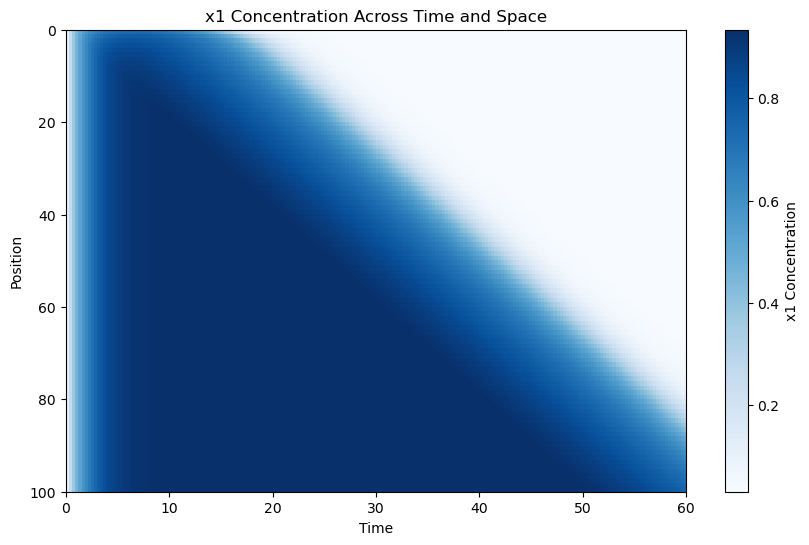

Reward for somitogenesis: 0.0


In [23]:

# test_weights = [-60, -150, 0, -109, 65, -66, -145, -41, 58] # -41(41), 58
test_weights = [44, -24, -26, 23, 55, 25, -51, 1, -3]
reward = somitogenesis_reward_func(test_weights, plot=True)
print(f"Reward for somitogenesis: {reward}")


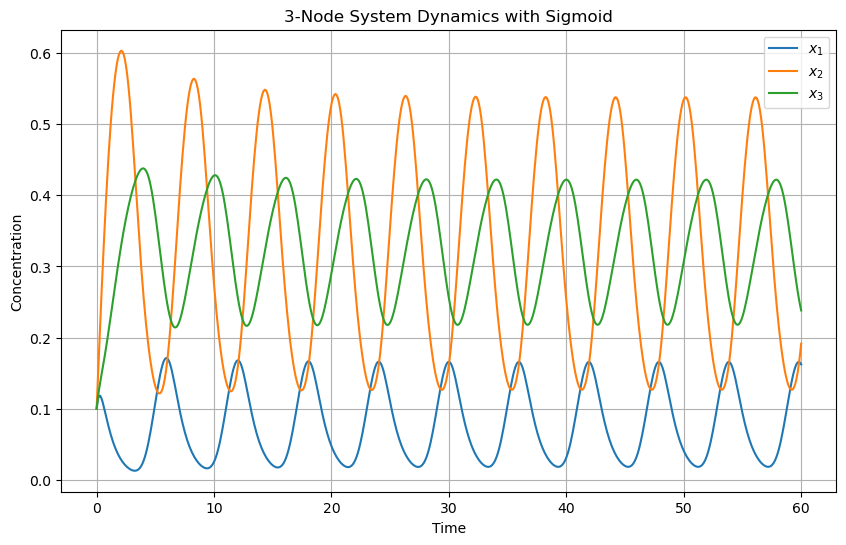

Reward for oscillator: 10


In [17]:
# test_weights = [-5, 2, 3, 1, 2, -1, 2, 1, -3] 
test_weights = [0, -10, 0, 4, 6, -10, -10, 0, 0]  # w12=-5, w22=..., w23=-10, w31=-10
reward = oscillator_reward_func(test_weights, plot=True)
print(f"Reward for oscillator: {reward}")

# Grid GFN 

In [24]:


def main(args):
    global losses, zs, agent
    
    assert args.envsize == args.mbsize
    set_seed(args.seed)
    set_device(torch.device(args.device))
    
    # Environment setup 
    envs = [GridEnv(args) for _ in range(args.envsize)]
    
    # Agent setup
    if args.method == 'tb':
        agent = TBFlowNetAgent(args, envs)
        opt = torch.optim.Adam([{'params': agent.parameters(), 'lr': args.tb_lr}, {'params':[agent.log_z], 'lr': args.tb_z_lr} ])
    elif args.method == 'db' or args.method == 'fldb':
        agent = DBFlowNetAgent(args, envs)
        opt = torch.optim.Adam([{'params': agent.parameters(), 'lr': args.tb_lr}])

    # Logging setup
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"{args.method}_h{args.n_hid}_l{args.n_layers}_mr{args.min_reward}_ts{args.n_train_steps}_d{args.n_dims}_s{args.n_steps}_er{args.explore_ratio}_et{args.enable_time}" 
    run_dir = os.path.join('runs', f'{timestamp}_{run_name}') 
    os.makedirs(run_dir, exist_ok=True)
    if args.log_flag:
        log_filename = os.path.join(run_dir, 'training.log') 
        log_arguments(log_filename, args)
        




    """Training Loop"""
    
    losses = [] 
    zs = []  # only for tb
    for i in tqdm(range(args.n_train_steps + 1), disable=not args.progress):
        experiences = agent.sample_batch_episodes(args.mbsize)
        if args.method == 'fldb':
            loss, z = agent.compute_batch_loss(experiences, use_fldb=True) 
        else:
            loss, z = agent.compute_batch_loss(experiences) 
            
        losses.append(loss.item())
        zs.append(z.item()) 

        loss.backward()
        opt.step()
        opt.zero_grad() 
        
        if i % args.log_freq == 0 and args.log_flag:
            log_training_loop(log_filename, agent, i)

    return losses, zs, agent





    # # Save 
    # save_variables(
    #     run_dir,
    #     {"losses": losses, "zs": zs, "agent": agent}
    # )



In [46]:

args = argparse.Namespace(
    device='cpu',
    progress=True,
    seed=0,
    n_train_steps=10,  # 2000
    log_freq=10,  # 1000
    log_flag=True,
    mbsize=16,
    # Model
    method='db', 
    learning_rate=1e-3,
    tb_lr=0.01,
    tb_z_lr=0.1,
    n_hid=256,
    n_layers=3,
    explore_ratio=0.05,  # 0.0625
    temp=1.,
    uni_rand_pb=1,
    # Env
    envsize=16,
    min_reward=0.01,
    custom_reward_fn=coord_reward_func,
    n_steps=8,  # 8 * 9 = 72
    n_dims=2,  # 9,  
    actions_per_dim=[1],  # [1, 5, 25, -1, -5, -25], # if inhomogenous, need to be a closed symmetrical group.
    grid_bound=10,  # 100,
    enable_time=False  # True
)



# Training
main(args)

print("losses: ", losses)


Sequential(
  (0): Linear(in_features=22, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=256, out_features=5, bias=True)
)
------------------------------------------
All available actions (action_names): 2
['(0): dim0 1', '(1): dim1 1']
------------------------------------------
None


100%|██████████| 11/11 [00:00<00:00, 22.43it/s]

losses:  [2.2572684288024902, 1.4411488771438599, 1.0032408237457275, 0.7854083776473999, 0.4172976016998291, 0.7515614032745361, 0.8204306364059448, 0.48073065280914307, 0.45726504921913147, 0.5745574235916138, 0.548069417476654]


# analysis

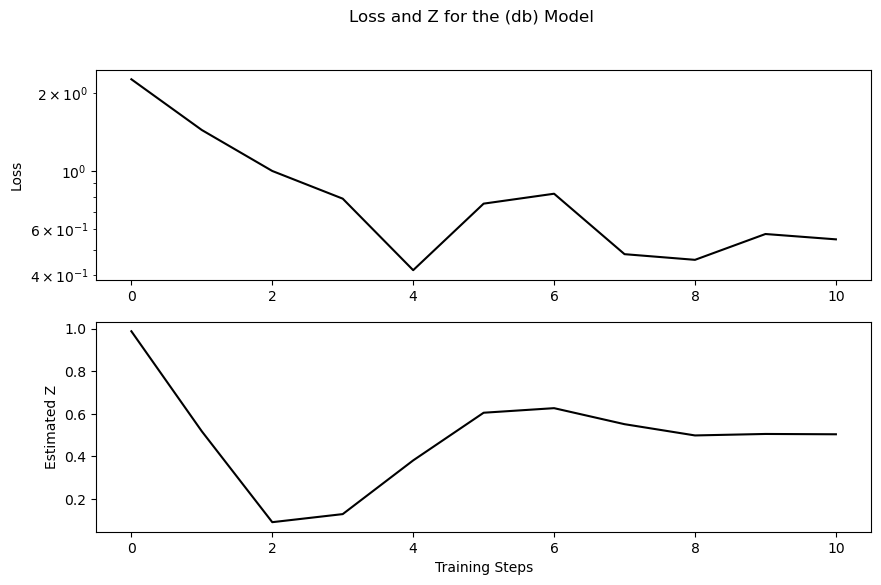

The final Z (partition function) estimate is 0.50


In [47]:
title = "Loss and Z for the ({}) Model".format(args.method)
plot_loss_curve(losses, zs=zs, title=title)
print("The final Z (partition function) estimate is {:.2f}".format(zs[-1]))

# print(agent.state_counts)
# print(agent.state_returns)

In [48]:
agent.env.print_actions()

------------------------------------------
All available actions (action_names): 2
['(0): dim0 1', '(1): dim1 1']
------------------------------------------


In [49]:
print("\n")
print("-" * 60)
print(f"Number of unique terminal states found: {len(agent.ep_last_state_counts)}")

print("-" * 30)
print("Top 12 by Avg avg trajectory rewards:")
print("-" * 30)

# Calculate average of average trajectory rewards for each state
state_avg_rewards = {}
for state, trajectories in agent.ep_last_state_trajectories.items():
    traj_avgs = []
    for traj in trajectories:
        rewards = [r[0] for r in traj['rewards']]
        traj_avgs.append(sum(rewards) / len(rewards))
    state_avg_rewards[state] = sum(traj_avgs) / len(traj_avgs)

# Sort states by state_avg_rewards
top_reward_states = sorted(
    state_avg_rewards.items(),
    key=lambda x: x[1],
    reverse=True
)[:12]

for state, avg_reward in top_reward_states:
    trajectories = agent.ep_last_state_trajectories[state]
    count = agent.ep_last_state_counts[state]
    terminal_reward = trajectories[0]['rewards'][-1][0]
    print(f"State: {state}, Count: {count}, Terminal reward: {terminal_reward:.3f}, Avg avg trajectory reward: {avg_reward:.3f}")
    
    # Print top 3 trajectories by average reward
    sorted_trajectories = sorted(
        trajectories,
        key=lambda t: sum(r[0] for r in t['rewards']) / len(t['rewards']),
        reverse=True
    )[:3]
    for traj in sorted_trajectories:
        rewards = [r[0] for r in traj['rewards']]
        traj_avg = sum(rewards) / len(rewards)
        print(f"Trajectory rewards: {[f'{r:.3f}' for r in rewards]}, Average: {traj_avg:.3f}")
    print("")

print("-" * 30)
print("Top 12 by visit count:")
print("-" * 30)

top_count_states = sorted(
    agent.ep_last_state_counts.items(),
    key=lambda x: x[1],
    reverse=True
)[:12]

for state, count in top_count_states:
    trajectories = agent.ep_last_state_trajectories[state]
    terminal_reward = trajectories[0]['rewards'][-1][0]
    print(f"State: {state}, Count: {count}, Terminal reward: {terminal_reward:.3f}, Avg avg trajectory reward: {state_avg_rewards[state]:.3f}")
    
    # Print top 3 trajectories by average reward
    sorted_trajectories = sorted(
        trajectories,
        key=lambda t: sum(r[0] for r in t['rewards']) / len(t['rewards']),
        reverse=True
    )[:3]
    for traj in sorted_trajectories:
        rewards = [r[0] for r in traj['rewards']]
        traj_avg = sum(rewards) / len(rewards)
        print(f"Trajectory rewards: {[f'{r:.3f}' for r in rewards]}, Average: {traj_avg:.3f}")
    print("")
print("\n")




------------------------------------------------------------
Number of unique terminal states found: 9
------------------------------
Top 12 by Avg avg trajectory rewards:
------------------------------
State: (0, 8), Count: 2, Terminal reward: 2.010, Avg avg trajectory reward: 0.385
Trajectory rewards: ['0.010', '0.010', '0.010', '0.010', '0.010', '1.010', '0.010', '2.010'], Average: 0.385
Trajectory rewards: ['0.010', '0.010', '0.010', '0.010', '0.010', '1.010', '0.010', '2.010'], Average: 0.385

State: (8, 0), Count: 3, Terminal reward: 2.010, Avg avg trajectory reward: 0.385
Trajectory rewards: ['0.010', '0.010', '0.010', '0.010', '0.010', '1.010', '0.010', '2.010'], Average: 0.385
Trajectory rewards: ['0.010', '0.010', '0.010', '0.010', '0.010', '1.010', '0.010', '2.010'], Average: 0.385
Trajectory rewards: ['0.010', '0.010', '0.010', '0.010', '0.010', '1.010', '0.010', '2.010'], Average: 0.385

State: (2, 6), Count: 27, Terminal reward: 1.010, Avg avg trajectory reward: 0.167
T

# testing

In [11]:

"""Test case: Mixed positive/negative actions"""

args_mixed = argparse.Namespace(
    min_reward=0.001,
    custom_reward_fn=coord_reward_func,
    n_steps=5,
    n_dims=2,
    actions_per_dim=[1, -1, 2, -2],  # Mixed positive and negative actions
    grid_bound=5,
    enable_time=True
)
env_mixed = GridEnv(args_mixed)
env_mixed.print_actions()
env_mixed.reset()

mixed_test_state = (17, [-5, -5])
print("forward: ", env_mixed.get_forward_mask(mixed_test_state))
print("backward: ", env_mixed.get_backward_mask(mixed_test_state))
print("step: ", env_mixed._step)
print()  # Add blank line between iterations



------------------------------------------
All available actions (action_names): 8
['(0): dim0 1', '(1): dim0 -1', '(2): dim0 2', '(3): dim0 -2', '(4): dim1 1', '(5): dim1 -1', '(6): dim1 2', '(7): dim1 -2']
------------------------------------------
forward:  [ True False  True False  True False  True False]
backward:  [False  True False  True False  True False  True]
step:  0



In [54]:
import time

# Function that simulates an expensive computation
def expensive_computation(x):
    time.sleep(0.1)  # Simulate work
    return x * 2

# Test without cache
print("Without cache:")
start_time = time.time()
for i in range(10):
    # Compute same values multiple times
    result = expensive_computation(i % 3)  # Only compute 0,1,2 repeatedly
    print(f"Computing {i % 3} -> {result}")
no_cache_time = time.time() - start_time
print(f"Time without cache: {no_cache_time:.2f}s\n")

# Test with cache
print("With cache:")
cache = LRUCache(max_size=3)
start_time = time.time()
for i in range(10):
    key = i % 3
    if key in cache:
        result = cache[key]
        print(f"Cache hit for {key} -> {result}")
    else:
        result = expensive_computation(key)
        cache[key] = result
        print(f"Cache miss for {key} -> {result}")
cache_time = time.time() - start_time
print(f"Time with cache: {cache_time:.2f}s")

print(f"\nCache speedup: {no_cache_time/cache_time:.1f}x faster")


Without cache:
Computing 0 -> 0
Computing 1 -> 2
Computing 2 -> 4
Computing 0 -> 0
Computing 1 -> 2
Computing 2 -> 4
Computing 0 -> 0
Computing 1 -> 2
Computing 2 -> 4
Computing 0 -> 0
Time without cache: 1.04s

With cache:
Cache miss for 0 -> 0
Cache miss for 1 -> 2
Cache miss for 2 -> 4
Cache hit for 0 -> 0
Cache hit for 1 -> 2
Cache hit for 2 -> 4
Cache hit for 0 -> 0
Cache hit for 1 -> 2
Cache hit for 2 -> 4
Cache hit for 0 -> 0
Time with cache: 0.31s

Cache speedup: 3.3x faster
